In [1]:
import numpy as np
from numpy.lib.format import open_memmap

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage import convolve1d as convolve

%matplotlib inline

sns.set_style('ticks')

# Equação de onda acustica 3D

Dado um sistema de coordenadas cartesiano $x$ (m), $y$ (m), $z$ (m), com o eixo $z$ orientado para baixo, considere a equação de onda acústica tridimensional 

$$
\frac{\partial^2 p}{\partial t^2} = v^2
    \left ( \frac{\partial^2 p}{\partial x^2} +
            \frac{\partial^2 p}{\partial y^2} +
            \frac{\partial^2 p}{\partial z^2}
    \right ) +
    v^2 \rho \psi(t) \delta (\mathbf x - \mathbf x_f),
$$

que relaciona a variação no tempo $t$ (s) do o campo de pressão $p$ com
a velocidade de volume de ondas acústicas $v$ (m/s), a densidade
do meio $\rho$ (kg/m³) e a fonte $\psi(\mathbf x, \mathbf x_f, t)$. Nesse caso o vetor $\mathbf x = (x,y,z)$ é o vetor posição e $\mathbf x_f = (x_f,y_f,z_f)$ é a posição da fonte.

## Parâmetrização da fonte


Como fonte vou utilizar uma [wavelet de Ricker](https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet) em tempo

$$
\psi(t) \equiv A \left ( 1 - 2 (\pi f_p t)^2 \right)
    \exp \left ( -(\pi f_p t)^2 \right)
$$

com amplitude de pico $A$ e frequência de pico $f_p$ (Hz). A transformada de fourier em frequência ordinária (Hz) dessa wavelet é

$$
\hat{\psi}(f) = \frac{2}{\sqrt{\pi}}\frac{f^2}{f_p^3}
    \exp \left ( -\frac{f^2}{f_p^2} \right ).
$$

Além disso, uma boa aproximação para a frequência máxima da fonte é dada<sup>[1]</sup> por

$$
f_c = \frac{3 \sqrt{\pi}}{2} f_p.
$$
O pulso fonte deve ser atrasado, para não haver problemas de causalidade, desse modo a fonte sísmica pode ser redefinida como

$$
\psi(t) \equiv A \left ( 1 - 2 (\pi f_p (t - t_d)^2 \right)
    \exp \left ( -(\pi f_p (t - t_d))^2 \right)
$$

Esse tempo de atraso $t_d$ (s) é estimado a partir de frequência de pico 

$$
t_d = \frac{1}{f_{p}}.
$$

In [2]:
def ricker(t, f_p = 25, A = 0.01):
    """
        Ricker no domínio do tempo
    """
    return A * (1 - 2*(np.pi*f_p*t)**2) * np.exp(-(np.pi*f_p*t)**2)

def ricker_freq(f,f_p = 25, A = 0.01):
    """
        Ricker no domínio da frequência
    """
    return 2/np.sqrt(np.pi) * f**2/f_p**3 * np.exp(-(f/f_p)**2)

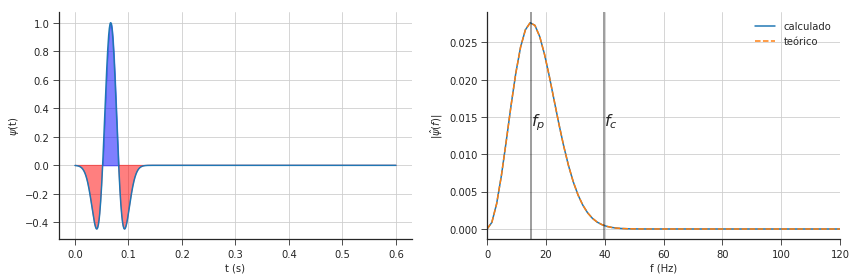

In [3]:
A = 1 # Amplitude da fonte
dt = 0.0006 # Amostragem em tempo (s)
nt = 1001 # número de intervalos de tempo
f_p = 15 # Freq. de pico (Hz)

f_c = 3*np.sqrt(np.pi)/2*f_p # Frequência de corte (Hz)
t_d = 1/f_p # Tempo de atraso (s)

t = np.arange(nt) * dt
y = ricker(t - t_d, f_p, A)

N = 1024

Y = np.fft.fft(y, n=N, axis=0) * dt
freq = np.fft.fftfreq(N, d=dt)


plt.figure(figsize=(12,4))
plt.subplot(121)

plt.plot(t, y)
plt.fill_between(t, y, 0,  y > 0.0, interpolate=False, color='blue', alpha = 0.5)
plt.fill_between(t, y, 0, y < 0.0, interpolate=False, color='red', alpha = 0.5)
plt.grid(True, which='both')
sns.despine()

plt.xlabel(u't (s)')
plt.ylabel(u'$\psi$(t)')

plt.subplot(122)

plt.plot(freq[freq >= 0], np.abs(Y)[freq >= 0], label='calculado')

plt.plot(freq[freq >= 0], ricker_freq(freq[freq >= 0], f_p), ls='--', label=u'teórico')
plt.axvline(f_p, color='k', alpha=0.5)
plt.text(f_p, np.abs(Y).max()/2, '$f_p$', fontsize=16)

plt.axvline(f_c, color='k', alpha=0.5)
plt.text(f_c, np.abs(Y).max()/2, '$f_c$', fontsize=16)

plt.xlabel('f (Hz)')
plt.ylabel('$|\hat{\psi}(f)|$')

plt.grid(True, which='both')

plt.legend()
plt.xlim(0,120)
sns.despine()

plt.tight_layout()


## Parâmetros físicos para o problema

### Implementação de teste com meio homogêneno

A fim de testar a implementação, primeiro vou implementar a solução usando um grid simples com meio homogêneo.

In [4]:
dx = 5 # m
dy = 5 # m
dz = 5 # m

nx = 101 # número de pontos no eixo x
ny = 101 # número de pontos no eixo y
nz = 121 # número de pontos no eixo z

x_f = 51 # Posição x da fonte (amostras)
y_f = 51 # Posição y da fonte (amostras)
z_f = 2 # Profundidade de fonte (amostras)

# Meio: Arenito poroso saturado com água
# OBS: Velocidade está muito subestimada
v_b = 2000 # Velocidade do meio (m/s)

rho_ma = 2650 # Densidade do arenito kg/m³
rho_f = 1100 # Densidade da água salgada (brine) kg/m³
phi = 0.22 # Porodidade do meio
rho_b = rho_ma * (1 - phi) + rho_f * phi # Densidade de volume kg/m³

print('Densidade do meio: %f' % rho_b)

v_b = np.ones((nx,ny,nz)) * v_b

assert dx < np.min(v_b)/(10*f_c), 'dx deve ser menor que %f' % (np.min(v_b)/(10*f_c))
assert dy < np.min(v_b)/(10*f_c), 'dz deve ser menor que %f' % (np.min(v_b)/(10*f_c))
assert dz < np.min(v_b)/(10*f_c), 'dz deve ser menor que %f' % (np.min(v_b)/(10*f_c))
assert dt < dx/(4*np.max(v_b)), 'dt deve ser menor que %f' % (dx/(4*np.max(v_b)))
assert dt < dz/(4*np.max(v_b)), 'dt deve ser menor que %f' % (dz/(4*np.max(v_b)))

Densidade do meio: 2309.000000


## Parâmetros para os gráficos

In [5]:
x = np.arange(nx) * dx
y = np.arange(ny) * dy
z = np.arange(nz) * dz

extent_x = [x[0], x[-1], z[0], z[-1]]
extent_y = [x[0], x[-1], z[0], z[-1]]

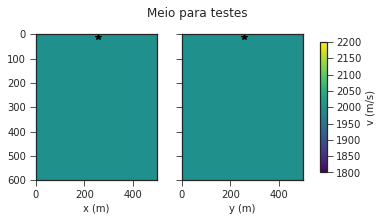

In [6]:
vmin = v_b.min() - 200
vmax = v_b.max() + 200

fig, axes = plt.subplots(nrows=1, ncols=2)
plt.suptitle('Meio para testes', y=.85)

im = axes[0].imshow(v_b[:,int(ny/2),:].T, extent=extent_x,
                    cmap='viridis', origin='upper left',
                    vmin=vmin, vmax=vmax)

axes[0].plot(x_f * dx, z_f * dz, 'k*', label='fonte')

axes[0].set_ylim(axes[0].get_ylim()[::-1])
axes[0].set_xlabel('x (m)')
axes[1].set_ylabel('z (m)')

im = axes[1].imshow(v_b[int(nx/2),:,:].T, extent=extent_y,
                    cmap='viridis', origin='upper left',
                    vmin=vmin, vmax=vmax)

axes[1].plot(y_f * dy, z_f * dz, 'k*', label='fonte')
axes[1].set_ylim(axes[1].get_ylim()[::-1])
axes[1].set_xlabel('y (m)')

plt.colorbar(im, ax=axes.ravel(), shrink=0.6, label='v (m/s)')

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass

## Malha simples e aproximação de segunda ordem no tempo de quarta ordem no espaço

A implementação da a aproximação de segunda ordem da equação de onda acustica no tempo e quarta ordem no espaço utilizando convolução e tensores é dada por

$$
P^{n+1} = - P^{n-1} + 2P^n + \Delta t^2 V \left (
    \frac{1}{\Delta x^2}
    P^n \overset{i}{*} \mathbf k
    +
    \frac{1}{\Delta y^2}
    P^n \overset{j}{*} \mathbf k
    +
    \frac{1}{\Delta z^2}
    P^n \overset{k}{*} \mathbf k
    \right )
    +
    \Delta t^2 V \rho \Psi^n
$$

com o kernel de convolução definido por

$$
   \mathbf k \equiv
   \frac{1}{12}
    \begin{bmatrix}
    -1 \\
    16 \\
    -30 \\
    16 \\
    -1
    \end{bmatrix},
$$ 

com a convolução 1D ao longo do eixo $i$ denotada por $\overset{i}{*}$ e assim por diante para os demais eixos.

Os seguintes termos são tensores de terceira ordem definidos como

$$
V \equiv \left[ v_{ijk}^2 \right]_{n_x n_y n_z},
$$

$$
P^n \equiv \left[ p_{ijk} \right]_{n_x n_y n_z},
$$

$$
\rho \equiv \left[ \rho_{ijk} \right]_{n_x n_y n_z}
$$

e

$$
\Psi^n \equiv \left[ \psi(n \Delta t) \delta_{i i_f} \delta_{j j_f}  \delta_{k k_f}\right]_{n_x n_y n_z}.
$$

Sendo $v_{ijk} = v(i\Delta x, j\Delta y, k\Delta z)$ a velocidade discretizada, $p_{ijk} = p(i\Delta x, j\Delta y, k\Delta z)$ o campo de pressão discretizado, $\rho_{ijk} = \rho(i\Delta x, j\Delta y, k\Delta z)$ a densidade discretizada. A posição da fonte é dada por $\mathbf x_f = (i_f \Delta x,j_f \Delta y, k_f \Delta z)$, sendo $(i_f,j_f,k_f)$ os índices da posição da fonte na malha discretizada. Os demais parâmetros são passo de tempo atual $n$, o intervalo de tempo $\Delta t$, os intervalos no espaço $\Delta x$, $\Delta y$ e $\Delta z$, o largura da malha $n_x$, o comprimento da malha $n_y$, e a profundidade da malha $n_z$.

## Bordas abosorventes

Para evitar o problema de reflexão nas bordas do modelo, vou utilizar a solução proposta por [Cerjan et al. (1985)](https://library.seg.org/doi/abs/10.1190/1.1441945), que consiste em aplicar uma borda absorvente na lateral da malha.

O primeiro passo é extender a malha em alguns pontos $n_d$ e depois aplicar uma função de perda exponencial nesses pontos extras para diminuir a amplitude do campo de onda modelado. Assim, dada a função de amortecimento $d_{ij}$ em cada ponto, o algoritmo para aplica-la é o seguinte:

1. Calcular $P^{n+1}$ conforme mostrado anteriormente.

2. Aplicar o amortecimento no tempo $n+1$ como $P^{n+1} \gets [p^{n+1}_{ij}d_{ij}]_{n_x,n_z}$.

3. Aplicar o amortecimento no tempo $n$ como $P^{n} \gets [p^{n}_{ij}d_{ij}]_{n_x,n_z}$.

4. Atualizar o campo no tempo $n - 1$ como $P^{n-1} \gets P^{n}$.

4. Atualizar o campo no tempo $n$ como $P^{n} \gets P^{n + 1}$.



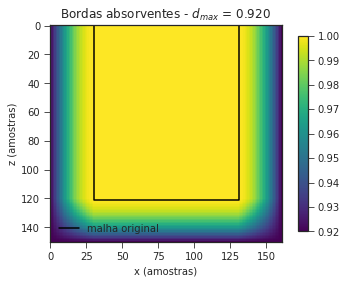

In [7]:
n_d = 30 # número de pontos de borda

damp_max = 0.92 # valor máximo de amortecimento
damp_max = 1 - np.sqrt(-np.log(damp_max))

damp = np.ones(v_b.shape)

pad_width=((n_d,n_d),(n_d,n_d),(0,n_d))

damp = np.pad(damp, pad_width=pad_width, mode='linear_ramp',
              end_values=damp_max)

damp = np.exp( -(1 - damp)**2)

im = plt.imshow(damp[:,int(ny/2),:].T, interpolation='nearest', cmap='viridis')
plt.colorbar(im, shrink=0.9)
plt.plot([n_d,n_d,nx+n_d,nx+n_d],[0,nz,nz,0], 'k', label='malha original')
plt.title('Bordas absorventes - $d_{max}$ = %.3f' % damp.min())

plt.xlabel('x (amostras)')
plt.ylabel('z (amostras)')
plt.legend();

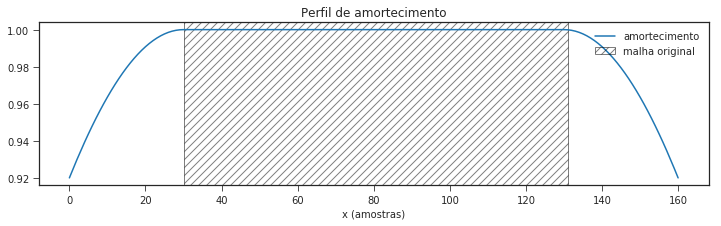

In [8]:
plt.figure(figsize=(12,3))
plt.plot(damp[:,int(ny/2),0], label='amortecimento')
plt.axvspan(n_d, n_d+nx, fill=False, hatch='///', alpha=0.5, label='malha original')
plt.xlabel('x (amostras)')

plt.legend(loc='upper right')
plt.title(u'Perfil de amortecimento');

### Simulação do experimento

In [9]:
# Fonte ao longo do experimento
t = np.arange(nt) * dt # eixo de tempo
psi = ricker(t - t_d, f_p, A) # Fonte discretizada

n_snap = 10 # Número de intervalos de tempo entre snapshots

print('Tempo total de simulação: %f ms', t[-1]*1000)
print('Intervalo entre snapshots: %f ms', n_snap*dt*1000)

Tempo total de simulação: %f ms 600.0
Intervalo entre snapshots: %f ms 5.999999999999999


In [10]:
kernel = np.array([-1,16,-30,16,-1])/12. # Convolution kernel

P_n = np.zeros(v_b.shape) # Campo de pressão atual
P_np = np.zeros(v_b.shape) # Campo de pressão passado
P_nf = np.zeros(v_b.shape) # Campo de pressão passado
V = v_b*v_b

# Realizando o padding
P_n = np.pad(P_n, pad_width=pad_width, mode='edge')
P_np = np.pad(P_np, pad_width=pad_width, mode='edge')
P_nf = np.pad(P_nf, pad_width=pad_width, mode='edge')
V = np.pad(V, pad_width=pad_width, mode='edge') * dt**2

mask = np.where(damp < 1) # mascara para aplicar o damping

n = np.sum([n % n_snap == 0 for n in np.arange(nt)])

# Os snapshots do campo completo ficam muito grandes em disco
# vou salvar somente uma inline
snaps = open_memmap('snapshots_fourth_order_3d.npy',
                    mode='w+', dtype=np.float,
                    shape=(P_n.shape[0], P_n.shape[2], n))

# Loop implementando as diferenças finitas
for n in np.arange(nt):
    P_nf = -P_np + 2*P_n + V *\
        (convolve(P_n, kernel/dx**2, axis=0, mode='constant') +\
         convolve(P_n, kernel/dy**2, axis=1, mode='constant') +\
         convolve(P_n, kernel/dz**2, axis=2, mode='constant'))
    P_nf[x_f+n_d,y_f+n_d,z_f] += psi[n] * V[x_f+n_d,y_f+n_d,z_f] * rho_b

    # Aplicando a borda absorvente
    P_nf[mask] = P_nf[mask] * damp[mask]
    P_n[mask] = P_n[mask] * damp[mask]
    
    # Atualizando os campos depois de aplicar a borda
    P_np = P_n
    P_n = P_nf

    if n % n_snap == 0:
        snaps[:,:, int(n/n_snap)] = P_n[:,n_d+y_f]

del snaps # Isso escreve o array em disco antes de remover

## Principais snapshots

In [11]:
def plot_snapshots(snaps, title, perc=99):
    perc = np.percentile(snaps.ravel(), 99)
    
    plt.figure(figsize=(12,6))
    plt.suptitle(title, y=0.8)

    for i in np.arange(5):
        if i == 0:
            ax = plt.subplot(1,5,i+1)
            plt.ylabel('z (m)')
        else:
            plt.subplot(1,5,i+1, sharey=ax)

        m = np.int(snaps.shape[2]/5) * i
        im = plt.imshow(snaps[:,:,m].T, cmap='gray_r', interpolation='nearest',
                        vmin=-perc, vmax=perc, extent=extent_x, origin='upper left')
        title = plt.title(u't = %.3f ms' % (m*dt))
        plt.xlabel('x (m)')

    plt.ylim(plt.ylim()[::-1])

    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass


    plt.tight_layout()

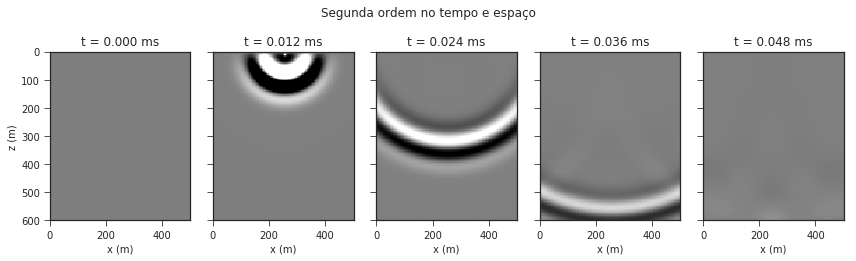

In [12]:
snaps = open_memmap('snapshots_fourth_order_3d.npy', mode='r')[n_d:-n_d,0:-n_d,:]
plot_snapshots(snaps, u'Segunda ordem no tempo e espaço')

## Referências

1 - Notas de aula de [MODELAGEM NUMÉRICA DE ONDAS SÍSMICAS](http://www.on.br/dppg/geofisica/ementa/MODELAGEM_NUMERICA_DE_ONDAS_SISMICAS_rev.pdf)

Cerjan, C., Kosloff, D., Kosloff, R. and Reshef, M., 1985. A nonreflecting boundary condition for discrete acoustic and elastic wave equations. Geophysics, 50(4), pp.705-708. https://library.seg.org/doi/abs/10.1190/1.1441945